LIVER CIRRHOSIS DETECTION USING DEEP LEARNING

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

In [4]:
dataset_paths = {
    "Cirrhosis_T1_3D": {
        "test_images": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T1_3D\test_images",
        "test_masks": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T1_3D\test_masks",
        "train_images": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T1_3D\train_images",
        "train_masks": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T1_3D\train_masks",
        "valid_images": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T1_3D\valid_images",
        "valid_masks": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T1_3D\valid_masks"
    },
    "Cirrhosis_T2_3D": {
        "test_images": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T2_3D\test_images",
        "test_masks": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T2_3D\test_masks",
        "train_images": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T2_3D\train_images",
        "train_masks": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T2_3D\train_masks",
        "valid_images": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T2_3D\valid_images",
        "valid_masks": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Cirrhosis_T2_3D\valid_masks"
    },
    "Healthy_subjects": {
        "T1_images": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Healthy_subjects\T1_W_Healthy\T1_images",
        "T1_masks": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Healthy_subjects\T1_W_Healthy\T1_masks",
        "T2_images": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Healthy_subjects\T2_W_Healthy\T2_images",
        "T2_masks": r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Healthy_subjects\T2_W_Healthy\T2_masks"
    }
}

In [ ]:
# Read .nii Data

def load_nifti_file(file_path):
    nii = nib.load(file_path)
    array = nii.get_fdata()
    return array

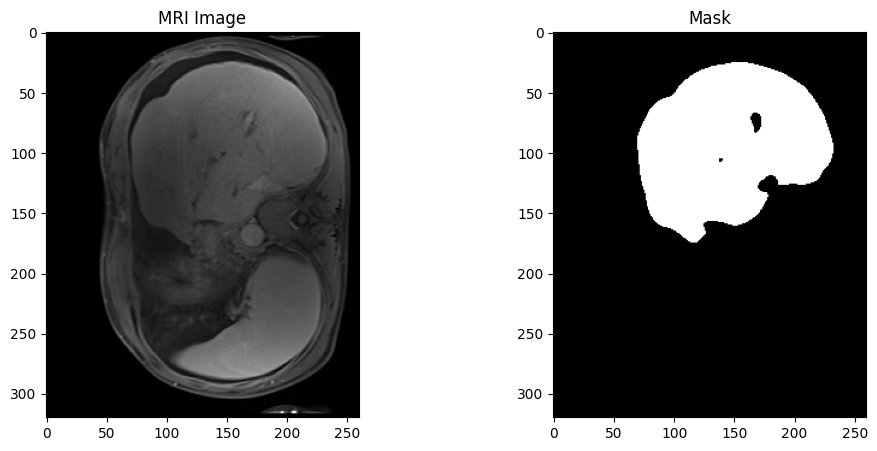

In [ ]:
# 3d Image Slicing

image_path = glob(os.path.join(dataset_paths["Cirrhosis_T1_3D"]["train_images"], "*.nii*"))[0]
mask_path = glob(os.path.join(dataset_paths["Cirrhosis_T1_3D"]["train_masks"], "*.nii*"))[0]

image_3d = load_nifti_file(image_path)
mask_3d = load_nifti_file(mask_path)

# Visualize the middle slice
slice_index = image_3d.shape[2] // 2

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_3d[:, :, slice_index], cmap='gray')
plt.title("MRI Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_3d[:, :, slice_index], cmap='gray')
plt.title("Mask")
plt.show()

In [3]:
# Labelling Data

import pandas as pd

# Load metadata from CSV file
csv_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Metadata\Label Data.csv"
df_labels = pd.read_csv(csv_path)

print(df_labels.head())

   Patient ID  Age  Gender  Radiological Evaluation
0           1   78       2                        0
1           2   54       2                        0
2           3   28       2                        3
3           4   52       2                        0
4           5   61       1                        1


In [120]:
import pandas as pd

# Load the CSV
csv_path = r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Metadata\Label Data.csv"
df_labels = pd.read_csv(csv_path)

# Clean the column names (remove trailing spaces, etc.)
df_labels.columns = df_labels.columns.str.strip()

# Define mappings
evaluation_map = {
    0: "Healthy Liver",
    1: "Early Stage Cirrhosis",
    2: "Mid Stage Cirrhosis",
    3: "Advanced Stage Cirrhosis",
}

gender_map = {
    1: "Female",
    2: "Male"
}

# Apply mappings to the proper columns
df_labels["Cirrhosis Stage"] = df_labels["Radiological Evaluation"].map(evaluation_map)
df_labels["Gender_Name"] = df_labels["Gender"].map(gender_map)

# Preview to confirm
df_labels.head()

,Patient ID,Age,Gender,Radiological Evaluation,Cirrhosis Stage,Gender_Name
0,1,78,2,0,Healthy Liver,Male
1,2,54,2,0,Healthy Liver,Male
2,3,28,2,3,Advanced Stage Cirrhosis,Male
3,4,52,2,0,Healthy Liver,Male
4,5,61,1,1,Early Stage Cirrhosis,Female


In [ ]:
#  Function to fetch label by filename 
def get_label_by_filename(filename):
    """
    Extract Patient ID from filename and return corresponding liver label.
    """
    base_name = os.path.basename(filename)
    match = re.match(r"^(\d+)", base_name)
    if match:
        patient_id = int(match.group(1))
        row = df_labels[df_labels["Patient ID"] == patient_id]
        if not row.empty:
            return row["Label_Name"].values[0]
    return None  

In [19]:
pip install nibabel opencv-python tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Slicing --> Converting .nii to jpg (3d to 2d) --> Preprocessing Data (Normalizing, Rescaling)

import nibabel as nib
import numpy as np
import cv2
import os
from tqdm import tqdm

def normalize_slice(slice_data):
    slice_data = np.clip(slice_data, a_min=0, a_max=None)
    slice_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data) + 1e-8)
    return (slice_data * 255).astype(np.uint8)

def slice_all_nifti_images(base_path, configs, num_slices=60, target_size=(256, 256)):
    for config in configs:
        category = config["category"]
        img_folder = config["img_folder"]
        mask_folder = config["mask_folder"]
        set_type = config["set_type"]  # train / test / valid

        img_dir = os.path.join(base_path, img_folder)
        mask_dir = os.path.join(base_path, mask_folder)

        output_img_dir = os.path.join(base_path, "Sliced", category, set_type + "_images")
        output_mask_dir = os.path.join(base_path, "Sliced", category, set_type + "_masks")
        os.makedirs(output_img_dir, exist_ok=True)
        os.makedirs(output_mask_dir, exist_ok=True)

        image_files = [f for f in os.listdir(img_dir) if f.endswith(".nii.gz")]

        for file in tqdm(image_files, desc=f"Slicing {category} [{set_type}]"):
            image_path = os.path.join(img_dir, file)
            mask_path = os.path.join(mask_dir, file)

            try:
                image_nii = nib.load(image_path)
                mask_nii = nib.load(mask_path)

                image_data = image_nii.get_fdata()
                mask_data = mask_nii.get_fdata()

                depth = image_data.shape[2]
                patient_id = os.path.splitext(os.path.splitext(file)[0])[0]

                for i in range(num_slices):
                    slice_index = int(i * depth / num_slices)
                    img_slice = normalize_slice(image_data[:, :, slice_index])
                    mask_slice = normalize_slice(mask_data[:, :, slice_index])

                    img_resized = cv2.resize(img_slice, target_size)
                    mask_resized = cv2.resize(mask_slice, target_size)

                    filename = f"{patient_id}_slice_{i}.jpg"
                    cv2.imwrite(os.path.join(output_img_dir, filename), img_resized)
                    cv2.imwrite(os.path.join(output_mask_dir, filename), mask_resized)

            except Exception as e:
                print(f" Error processing {file}: {e}")

#   Base path
base_dataset_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis"

configs = [
    # Cirrhosis T1
    {"category": "Cirrhosis_T1_3D", "img_folder": "Cirrhosis_T1_3D\\train_images", "mask_folder": "Cirrhosis_T1_3D\\train_masks", "set_type": "train"},
    {"category": "Cirrhosis_T1_3D", "img_folder": "Cirrhosis_T1_3D\\test_images", "mask_folder": "Cirrhosis_T1_3D\\test_masks", "set_type": "test"},
    {"category": "Cirrhosis_T1_3D", "img_folder": "Cirrhosis_T1_3D\\valid_images", "mask_folder": "Cirrhosis_T1_3D\\valid_masks", "set_type": "valid"},

    # Cirrhosis T2
    {"category": "Cirrhosis_T2_3D", "img_folder": "Cirrhosis_T2_3D\\train_images", "mask_folder": "Cirrhosis_T2_3D\\train_masks", "set_type": "train"},
    {"category": "Cirrhosis_T2_3D", "img_folder": "Cirrhosis_T2_3D\\test_images", "mask_folder": "Cirrhosis_T2_3D\\test_masks", "set_type": "test"},
    {"category": "Cirrhosis_T2_3D", "img_folder": "Cirrhosis_T2_3D\\valid_images", "mask_folder": "Cirrhosis_T2_3D\\valid_masks", "set_type": "valid"},

    # Healthy T1
    {"category": "Healthy_subjects\\T1_W_Healthy", "img_folder": "Healthy_subjects\\T1_W_Healthy\\T1_images", "mask_folder": "Healthy_subjects\\T1_W_Healthy\\T1_masks", "set_type": "train"},

    # Healthy T2
    {"category": "Healthy_subjects\\T2_W_Healthy", "img_folder": "Healthy_subjects\\T2_W_Healthy\\T2_images", "mask_folder": "Healthy_subjects\\T2_W_Healthy\\T2_masks", "set_type": "train"},
]

#  Run it
slice_all_nifti_images(base_dataset_path, configs)

Slicing Healthy_subjects\T2_W_Healthy [train]: 100%|██████████| 55/55 [00:47<00:00,  1.15it/s]


📊 Total sliced images in each folder:

📁 Cirrhosis_T1_3D\test_images: 1860 images
📁 Cirrhosis_T1_3D\train_images: 14880 images
📁 Cirrhosis_T1_3D\valid_images: 1860 images
📁 Cirrhosis_T2_3D\test_images: 1860 images
📁 Cirrhosis_T2_3D\train_images: 15360 images
📁 Cirrhosis_T2_3D\valid_images: 1860 images
📁 Healthy_subjects\T1_W_Healthy\train_images: 3300 images
📁 Healthy_subjects\T2_W_Healthy\train_images: 3300 images

 Showing 4 random sliced sample images:


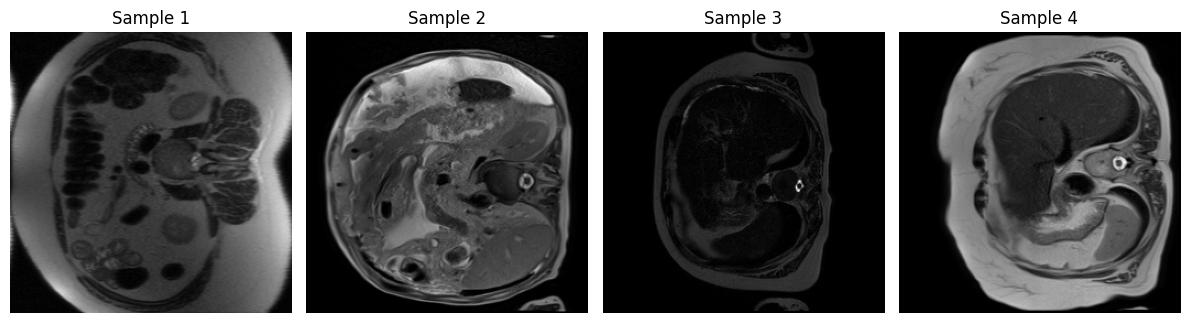

In [99]:
# Display total number of images in Sliced folders and show 4 random sample images

import random
import glob
import cv2
import matplotlib.pyplot as plt
import os

base_dataset_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis"

print("📊 Total sliced images in each folder:\n")

sliced_images = []

# Walk through all *_images folders in Sliced directory
for root, dirs, files in os.walk(os.path.join(base_dataset_path, "Sliced")):
    if root.endswith("_images"):
        jpg_files = [f for f in files if f.endswith(".jpg")]
        if jpg_files:
            relative_path = os.path.relpath(root, os.path.join(base_dataset_path, "Sliced"))
            print(f"📁 {relative_path}: {len(jpg_files)} images")
            sliced_images.extend([os.path.join(root, f) for f in jpg_files])

# Display 4 random sample images
print("\n Showing 4 random sliced sample images:")

sample_images = random.sample(sliced_images, min(4, len(sliced_images)))

plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def overlay_mask_on_image(image, mask, alpha=0.4):
    """Apply a precise, vibrant green overlay while keeping the background clear."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    if mask.shape != image.shape:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    green_mask = np.zeros_like(image_rgb)
    green_mask[:, :, 1] = 200 

    mask_binary = (mask > 50).astype(np.uint8)  
    green_region = green_mask * mask_binary[:, :, None]

    overlayed = cv2.addWeighted(image_rgb, 1, green_region, alpha, 0)

    return overlayed

def overlay_all_sliced_images(base_path, categories):
    """Process all images and overlay masks while keeping background visible."""
    for config in categories:
        category = config["category"]
        set_type = config["set_type"]

        image_dir = os.path.join(base_path, "Sliced", category, f"{set_type}_images")
        mask_dir = os.path.join(base_path, "Sliced", category, f"{set_type}_masks")
        output_dir = os.path.join(base_path, "Overlayed", category, set_type)
        os.makedirs(output_dir, exist_ok=True)

        image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

        for file in tqdm(image_files, desc=f"Overlaying {category} [{set_type}]"):
            img_path = os.path.join(image_dir, file)
            mask_path = os.path.join(mask_dir, file)

            if not os.path.exists(mask_path):
                print(f"⚠️ Mask not found for: {file}")
                continue

            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            overlayed = overlay_mask_on_image(image, mask)
            output_path = os.path.join(output_dir, file)
            cv2.imwrite(output_path, overlayed)

#  Base path
base_dataset_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis"

#  Categories for processing
categories = [
    {"category": "Cirrhosis_T1_3D", "set_type": "train"},
    {"category": "Cirrhosis_T1_3D", "set_type": "test"},
    {"category": "Cirrhosis_T1_3D", "set_type": "valid"},
    {"category": "Cirrhosis_T2_3D", "set_type": "train"},
    {"category": "Cirrhosis_T2_3D", "set_type": "test"},
    {"category": "Cirrhosis_T2_3D", "set_type": "valid"},
    {"category": "Healthy_subjects\\T1_W_Healthy", "set_type": "train"},
    {"category": "Healthy_subjects\\T2_W_Healthy", "set_type": "train"},
]

#  Run it
overlay_all_sliced_images(base_dataset_path, categories)


Overlaying Healthy_subjects\T2_W_Healthy [train]: 100%|██████████| 3300/3300 [00:23<00:00, 141.31it/s]


📊 Total overlayed images in each folder:

📁 Cirrhosis_T1_3D\test: 1860 images
📁 Cirrhosis_T1_3D\train: 14880 images
📁 Cirrhosis_T1_3D\valid: 1860 images
📁 Cirrhosis_T2_3D\test: 1860 images
📁 Cirrhosis_T2_3D\train: 15360 images
📁 Cirrhosis_T2_3D\valid: 1860 images
📁 Healthy_subjects\T1_W_Healthy\train: 3300 images
📁 Healthy_subjects\T2_W_Healthy\train: 3300 images

 Showing 4 random overlayed images:


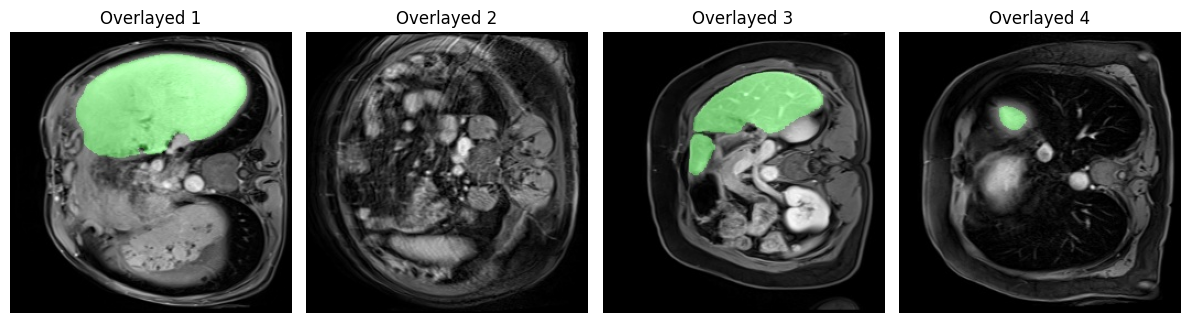

In [116]:
# Display total number of images and 4 random overlayed images from the Overlayed folders

import random
import glob
import cv2
import matplotlib.pyplot as plt
import os

base_dataset_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis"

# Print total images per folder
print("📊 Total overlayed images in each folder:\n")

overlayed_root = os.path.join(base_dataset_path, "Overlayed")
all_overlayed_images = []

for root, dirs, files in os.walk(overlayed_root):
    jpg_files = [f for f in files if f.endswith(".jpg")]
    if jpg_files:
        relative_path = os.path.relpath(root, overlayed_root)
        print(f"📁 {relative_path}: {len(jpg_files)} images")
        all_overlayed_images.extend([os.path.join(root, f) for f in jpg_files])

# Display 4 random overlayed images
print("\n Showing 4 random overlayed images:")

sample_overlayed = random.sample(all_overlayed_images, min(4, len(all_overlayed_images)))

plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_overlayed):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Overlayed {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def extract_green_region(image):
    """Accurately extracts the green liver region and removes gaps or black spots."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_green = np.array([35, 40, 40])   
    upper_green = np.array([95, 255, 255])

    mask = cv2.inRange(hsv, lower_green, upper_green)

    kernel = np.ones((5, 5), np.uint8)  
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   

    segmented = np.zeros_like(image)
    segmented[mask > 0] = image[mask > 0]

    return segmented

def segment_all_overlayed_images(base_path, categories):
    for config in categories:
        category = config["category"]
        set_type = config["set_type"]

        overlay_dir = os.path.join(base_path, "Overlayed", category, set_type)
        output_dir = os.path.join(base_path, "Segmented", category, set_type)
        os.makedirs(output_dir, exist_ok=True)

        image_files = [f for f in os.listdir(overlay_dir) if f.endswith(".jpg")]

        for file in tqdm(image_files, desc=f"Segmenting {category} [{set_type}]"):
            img_path = os.path.join(overlay_dir, file)
            image = cv2.imread(img_path)

            segmented = extract_green_region(image)
            output_path = os.path.join(output_dir, file)
            cv2.imwrite(output_path, segmented)

#  Base path
base_dataset_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis"

#  Categories for processing
categories = [
    {"category": "Cirrhosis_T1_3D", "set_type": "train"},
    {"category": "Cirrhosis_T1_3D", "set_type": "test"},
    {"category": "Cirrhosis_T1_3D", "set_type": "valid"},
    {"category": "Cirrhosis_T2_3D", "set_type": "train"},
    {"category": "Cirrhosis_T2_3D", "set_type": "test"},
    {"category": "Cirrhosis_T2_3D", "set_type": "valid"},
    {"category": "Healthy_subjects\\T1_W_Healthy", "set_type": "train"},
    {"category": "Healthy_subjects\\T2_W_Healthy", "set_type": "train"},
]

#  Run segmentation
segment_all_overlayed_images(base_dataset_path, categories)

Segmenting Healthy_subjects\T2_W_Healthy [train]: 100%|██████████| 3300/3300 [00:43<00:00, 76.63it/s]


📊 Total segmented images in each folder:

📁 Cirrhosis_T1_3D\test: 1860 images
📁 Cirrhosis_T1_3D\train: 14880 images
📁 Cirrhosis_T1_3D\valid: 1860 images
📁 Cirrhosis_T2_3D\test: 1860 images
📁 Cirrhosis_T2_3D\train: 15360 images
📁 Cirrhosis_T2_3D\valid: 1860 images
📁 Healthy_subjects\T1_W_Healthy\train: 3300 images
📁 Healthy_subjects\T2_W_Healthy\train: 3300 images

 Showing 4 random segmented images:


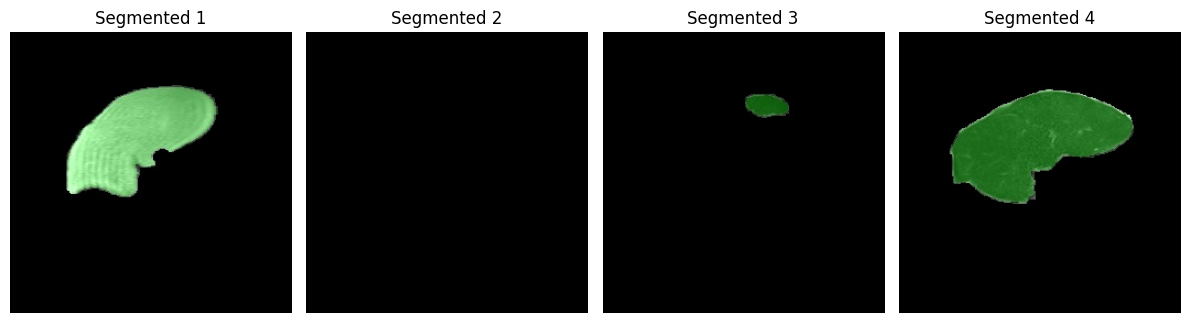

In [91]:
import random
import glob
import cv2
import matplotlib.pyplot as plt
import os

# Base path
base_dataset_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis"

# Collect and display image counts per folder
print("📊 Total segmented images in each folder:\n")

segmented_root = os.path.join(base_dataset_path, "Segmented")
all_segmented_images = []

for root, dirs, files in os.walk(segmented_root):
    jpg_files = [f for f in files if f.endswith('.jpg')]
    if jpg_files:
        relative_folder = os.path.relpath(root, segmented_root)
        print(f"📁 {relative_folder}: {len(jpg_files)} images")
        all_segmented_images.extend([os.path.join(root, f) for f in jpg_files])

# Display 4 random segmented images
print("\n Showing 4 random segmented images:")

sample_segmented = random.sample(all_segmented_images, min(4, len(all_segmented_images)))

plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_segmented):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Segmented {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
MODEL TRAINING - (CNN, GCNN, RESNET50, UNET, DENSENET)

C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1216/1216 ━━━━━━━━━━━━━━━━━━━━ 298s 244ms/step - accuracy: 0.4672 - loss: 1.1529


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


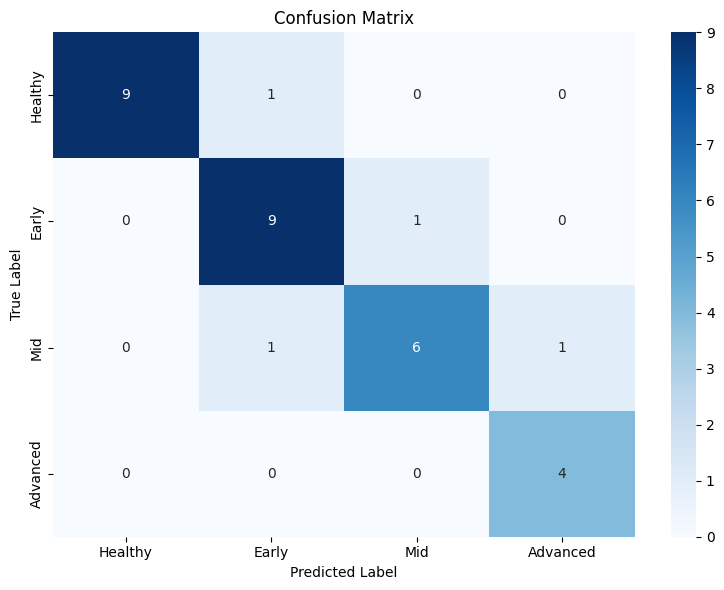


📊 Training Metrics:
      Metric    Value
   Accuracy 0.875000
 Error Rate 0.125000
  Precision 0.882468
     Recall 0.875000
   F1 Score 0.875021
    ROC AUC 0.973509
        MSE 0.059813
       RMSE 0.244566
        TPR 1.000000
        TNR 0.900000
        FPR 0.100000
        FNR 0.000000
 Dense Rate 0.000000
Dense Ratio 0.000000


In [ ]:
# CNN Model Training

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from PIL import Image

label_csv_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Metadata\Label Data.csv"
df = pd.read_csv(label_csv_path)
df.columns = df.columns.str.strip()

# Mapping
label_map = {0: "Healthy Liver", 1: "Early Stage Cirrhosis", 2: "Mid Stage Cirrhosis", 3: "Advanced Stage Cirrhosis"}
gender_map = {1: "Female", 2: "Male"}

# Apply mappings
df["Label_Name"] = df["Radiological Evaluation"].map(label_map)
df["Gender_Name"] = df["Gender"].map(gender_map)

# Train Data Paths 
train_dirs = [
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T1_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T2_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T1_W_Healthy\T1_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T2_W_Healthy\T2_images"
]

# Prepare image info
image_info = []
for train_dir in train_dirs:
    for file in os.listdir(train_dir):
        if file.endswith(".jpg"):
            path = os.path.join(train_dir, file)
            try:
                patient_id = int(file.split("_")[0])
                matched = df[df["Patient ID"] == patient_id]
                if not matched.empty:
                    label = matched["Radiological Evaluation"].values[0]
                    age = matched["Age"].values[0]
                    gender = matched["Gender"].values[0]
                    image_info.append((path, label, age, gender))
            except:
                continue

# DataGenerator
class LiverDataGenerator(Sequence):
    def __init__(self, image_info, batch_size=32, image_size=(128, 128), shuffle=True):
        self.image_info = image_info
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.image_info) / self.batch_size))
    
    def __getitem__(self, index):
        batch_info = self.image_info[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_labels = [], []
        self.dense_rates, self.dense_ratios = [], []
        
        for path, label, age, gender in batch_info:
            try:
                img = Image.open(path).resize(self.image_size).convert("RGB")
                img_np = np.array(img) / 255.0

                green_mask = (img_np[:, :, 1] > 100) & (img_np[:, :, 0] < 80) & (img_np[:, :, 2] < 80)
                liver_pixels = np.sum(green_mask)
                total_pixels = self.image_size[0] * self.image_size[1]

                dense_rate = liver_pixels / total_pixels
                dense_ratio = liver_pixels / (np.count_nonzero(np.sum(img_np, axis=2)) + 1)

                self.dense_rates.append(dense_rate)
                self.dense_ratios.append(dense_ratio)

                batch_images.append(img_np)
                batch_labels.append(label)
            except:
                continue
        
        X = np.array(batch_images)
        y = to_categorical(batch_labels, num_classes=4)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_info)

# Generator
train_generator = LiverDataGenerator(image_info, batch_size=32)

# CNN Architecture (standard, no grouped convs)
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator, epochs=1)

# Save model
model.save("cnn_model.h5")

# Predict on first batch
X_test, y_test = train_generator[0]
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
labels = ["Healthy", "Early", "Mid", "Advanced"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_image.png")
plt.show()

# Classification Metrics
report = classification_report(y_true, y_pred_classes, output_dict=True)
roc_auc = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

TP = conf_matrix[1][1] if conf_matrix.shape[0] > 1 else 0
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] if conf_matrix.shape[1] > 1 else 0
FN = conf_matrix[1][0] if conf_matrix.shape[0] > 1 else 0

accuracy = np.trace(conf_matrix) / conf_matrix.sum()
error_rate = 1 - accuracy
tpr = TP / (TP + FN) if (TP + FN) else 0
tnr = TN / (TN + FP) if (TN + FP) else 0
fpr = FP / (FP + TN) if (FP + TN) else 0
fnr = FN / (FN + TP) if (FN + TP) else 0

avg_dense_rate = np.mean(train_generator.dense_rates)
avg_dense_ratio = np.mean(train_generator.dense_ratios)

# Metrics Table
metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Error Rate", "Precision", "Recall", "F1 Score", "ROC AUC", "MSE", "RMSE", "TPR", "TNR", "FPR", "FNR", "Dense Rate", "Dense Ratio"],
    "Value": [
        accuracy,
        error_rate,
        report["weighted avg"]["precision"],
        report["weighted avg"]["recall"],
        report["weighted avg"]["f1-score"],
        roc_auc,
        mse,
        rmse,
        tpr,
        tnr,
        fpr,
        fnr,
        avg_dense_rate,
        avg_dense_ratio
    ]
})

print("\n📊 Training Metrics:\n", metrics_table.to_string(index=False))


C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2184s 2s/step - accuracy: 0.5169 - loss: 1.0568


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


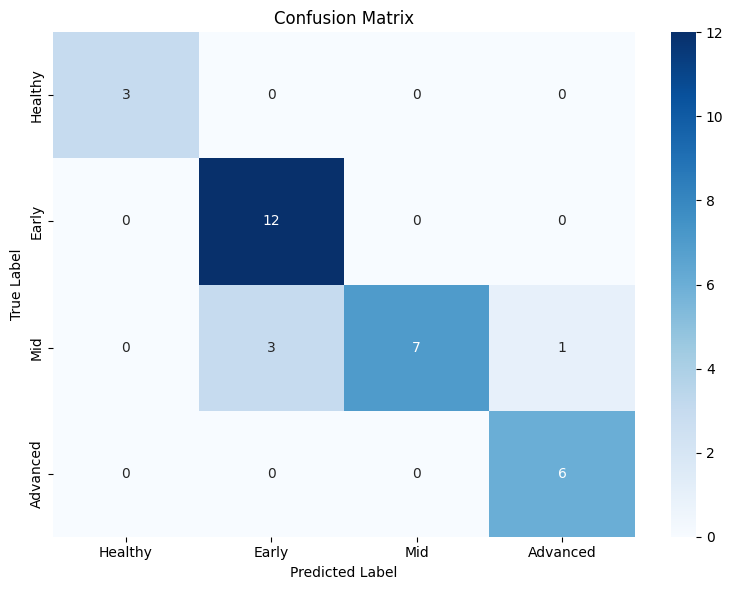


📊 Training Metrics:
      Metric    Value
   Accuracy 0.875000
 Error Rate 0.125000
  Precision 0.898214
     Recall 0.875000
   F1 Score 0.867521
    ROC AUC 0.992505
        MSE 0.038432
       RMSE 0.196042
        TPR 1.000000
        TNR 1.000000
        FPR 0.000000
        FNR 0.000000
 Dense Rate 0.000000
Dense Ratio 0.000000


In [ ]:
# GCNN Model Training

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from PIL import Image

# Load and clean CSV
label_csv_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Metadata\Label Data.csv"
df = pd.read_csv(label_csv_path)
df.columns = df.columns.str.strip()

# Mapping
label_map = {0: "Healthy Liver", 1: "Early Stage Cirrhosis", 2: "Mid Stage Cirrhosis", 3: "Advanced Stage Cirrhosis"}
gender_map = {1: "Female", 2: "Male"}

# Apply mappings
df["Label_Name"] = df["Radiological Evaluation"].map(label_map)
df["Gender_Name"] = df["Gender"].map(gender_map)

# Train Data Paths
train_dirs = [
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T1_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T2_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T1_W_Healthy\T1_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T2_W_Healthy\T2_images"
]

# Prepare image info
image_info = []
for train_dir in train_dirs:
    for file in os.listdir(train_dir):
        if file.endswith(".jpg"):
            path = os.path.join(train_dir, file)
            try:
                patient_id = int(file.split("_")[0])
                matched = df[df["Patient ID"] == patient_id]
                if not matched.empty:
                    label = matched["Radiological Evaluation"].values[0]
                    age = matched["Age"].values[0]
                    gender = matched["Gender"].values[0]
                    image_info.append((path, label, age, gender))
            except:
                continue

# DataGenerator
class LiverDataGenerator(Sequence):
    def __init__(self, image_info, batch_size=32, image_size=(128, 128), shuffle=True):
        self.image_info = image_info
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.image_info) / self.batch_size))
    
    def __getitem__(self, index):
        batch_info = self.image_info[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_labels = [], []
        self.dense_rates, self.dense_ratios = [], []
        
        for path, label, age, gender in batch_info:
            try:
                img = Image.open(path).resize(self.image_size).convert("RGB")
                img_np = np.array(img) / 255.0

                green_mask = (img_np[:, :, 1] > 100) & (img_np[:, :, 0] < 80) & (img_np[:, :, 2] < 80)
                liver_pixels = np.sum(green_mask)
                total_pixels = self.image_size[0] * self.image_size[1]

                dense_rate = liver_pixels / total_pixels
                dense_ratio = liver_pixels / (np.count_nonzero(np.sum(img_np, axis=2)) + 1)

                self.dense_rates.append(dense_rate)
                self.dense_ratios.append(dense_ratio)

                batch_images.append(img_np)
                batch_labels.append(label)
            except:
                continue
        
        X = np.array(batch_images)
        y = to_categorical(batch_labels, num_classes=4)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_info)

# Generator
train_generator = LiverDataGenerator(image_info, batch_size=32)

# GCNN Architecture
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same', groups=1),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same', groups=2),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same', groups=4),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator, epochs=1)

# Save model
model.save("gcnn_model.h5")

# Predict on first batch
X_test, y_test = train_generator[0]
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
labels = ["Healthy", "Early", "Mid", "Advanced"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_image.png")
plt.show()

# Classification Metrics
report = classification_report(y_true, y_pred_classes, output_dict=True)
roc_auc = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

TP = conf_matrix[1][1] if conf_matrix.shape[0] > 1 else 0
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] if conf_matrix.shape[1] > 1 else 0
FN = conf_matrix[1][0] if conf_matrix.shape[0] > 1 else 0

accuracy = np.trace(conf_matrix) / conf_matrix.sum()
error_rate = 1 - accuracy
tpr = TP / (TP + FN) if (TP + FN) else 0
tnr = TN / (TN + FP) if (TN + FP) else 0
fpr = FP / (FP + TN) if (FP + TN) else 0
fnr = FN / (FN + TP) if (FN + TP) else 0

avg_dense_rate = np.mean(train_generator.dense_rates)
avg_dense_ratio = np.mean(train_generator.dense_ratios)

# Metrics Table
metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Error Rate", "Precision", "Recall", "F1 Score", "ROC AUC", "MSE", "RMSE", "TPR", "TNR", "FPR", "FNR", "Dense Rate", "Dense Ratio"],
    "Value": [
        accuracy,
        error_rate,
        report["weighted avg"]["precision"],
        report["weighted avg"]["recall"],
        report["weighted avg"]["f1-score"],
        roc_auc,
        mse,
        rmse,
        tpr,
        tnr,
        fpr,
        fnr,
        avg_dense_rate,
        avg_dense_ratio
    ]
})

print("\n📊 Training Metrics:\n", metrics_table.to_string(index=False))


C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1216/1216 ━━━━━━━━━━━━━━━━━━━━ 650s 530ms/step - accuracy: 0.3493 - loss: 1.3252


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


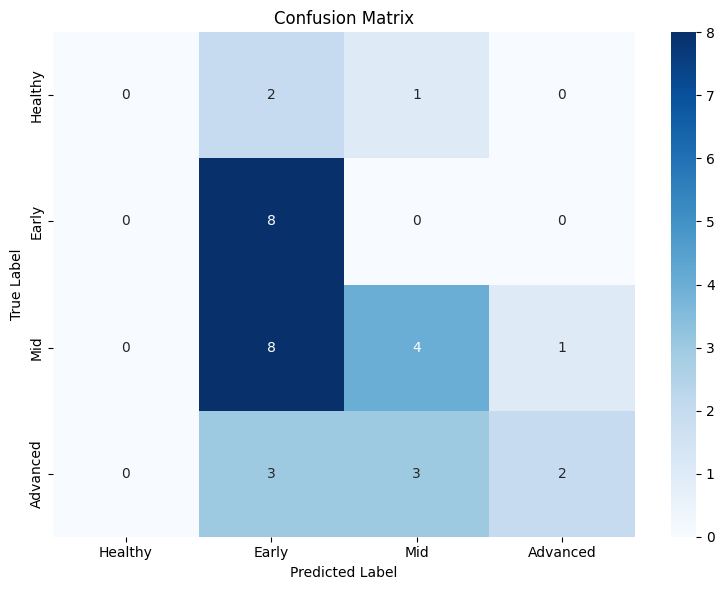


📊 Training Metrics:
      Metric    Value
   Accuracy 0.437500
 Error Rate 0.562500
  Precision 0.465030
     Recall 0.437500
   F1 Score 0.383602
    ROC AUC 0.734901
        MSE 0.166254
       RMSE 0.407743
        TPR 1.000000
        TNR 0.000000
        FPR 1.000000
        FNR 0.000000
 Dense Rate 0.000000
Dense Ratio 0.000000


C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

In [ ]:
# ResNet50 Model Training

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications import ResNet50
from PIL import Image

# Load and clean CSV
label_csv_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Metadata\Label Data.csv"
df = pd.read_csv(label_csv_path)
df.columns = df.columns.str.strip()

# Mapping
label_map = {0: "Healthy Liver", 1: "Early Stage Cirrhosis", 2: "Mid Stage Cirrhosis", 3: "Advanced Stage Cirrhosis"}
gender_map = {1: "Female", 2: "Male"}

# Apply mappings
df["Label_Name"] = df["Radiological Evaluation"].map(label_map)
df["Gender_Name"] = df["Gender"].map(gender_map)

# Train Data Paths 
train_dirs = [
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T1_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T2_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T1_W_Healthy\T1_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T2_W_Healthy\T2_images"
]

# Prepare image info
image_info = []
for train_dir in train_dirs:
    for file in os.listdir(train_dir):
        if file.endswith(".jpg"):
            path = os.path.join(train_dir, file)
            try:
                patient_id = int(file.split("_")[0])
                matched = df[df["Patient ID"] == patient_id]
                if not matched.empty:
                    label = matched["Radiological Evaluation"].values[0]
                    age = matched["Age"].values[0]
                    gender = matched["Gender"].values[0]
                    image_info.append((path, label, age, gender))
            except:
                continue

# DataGenerator
class LiverDataGenerator(Sequence):
    def __init__(self, image_info, batch_size=32, image_size=(128, 128), shuffle=True):
        self.image_info = image_info
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.image_info) / self.batch_size))
    
    def __getitem__(self, index):
        batch_info = self.image_info[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_labels = [], []
        self.dense_rates, self.dense_ratios = [], []
        
        for path, label, age, gender in batch_info:
            try:
                img = Image.open(path).resize(self.image_size).convert("RGB")
                img_np = np.array(img) / 255.0

                green_mask = (img_np[:, :, 1] > 100) & (img_np[:, :, 0] < 80) & (img_np[:, :, 2] < 80)
                liver_pixels = np.sum(green_mask)
                total_pixels = self.image_size[0] * self.image_size[1]

                dense_rate = liver_pixels / total_pixels
                dense_ratio = liver_pixels / (np.count_nonzero(np.sum(img_np, axis=2)) + 1)

                self.dense_rates.append(dense_rate)
                self.dense_ratios.append(dense_ratio)

                batch_images.append(img_np)
                batch_labels.append(label)
            except:
                continue
        
        X = np.array(batch_images)
        y = to_categorical(batch_labels, num_classes=4)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_info)

# Generator
train_generator = LiverDataGenerator(image_info, batch_size=32)

# ResNet50 Model (replaces GCNN)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False  # freeze weights for lighter training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator, epochs=1)

# Save model
model.save("resnet50_model.h5")

# Predict on first batch
X_test, y_test = train_generator[0]
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
labels = ["Healthy", "Early", "Mid", "Advanced"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_image.png")
plt.show()

# Classification Metrics
report = classification_report(y_true, y_pred_classes, output_dict=True)
roc_auc = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

TP = conf_matrix[1][1] if conf_matrix.shape[0] > 1 else 0
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] if conf_matrix.shape[1] > 1 else 0
FN = conf_matrix[1][0] if conf_matrix.shape[0] > 1 else 0

accuracy = np.trace(conf_matrix) / conf_matrix.sum()
error_rate = 1 - accuracy
tpr = TP / (TP + FN) if (TP + FN) else 0
tnr = TN / (TN + FP) if (TN + FP) else 0
fpr = FP / (FP + TN) if (FP + TN) else 0
fnr = FN / (FN + TP) if (FN + TP) else 0

avg_dense_rate = np.mean(train_generator.dense_rates)
avg_dense_ratio = np.mean(train_generator.dense_ratios)

# Metrics Table
metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Error Rate", "Precision", "Recall", "F1 Score", "ROC AUC", "MSE", "RMSE", "TPR", "TNR", "FPR", "FNR", "Dense Rate", "Dense Ratio"],
    "Value": [
        accuracy,
        error_rate,
        report["weighted avg"]["precision"],
        report["weighted avg"]["recall"],
        report["weighted avg"]["f1-score"],
        roc_auc,
        mse,
        rmse,
        tpr,
        tnr,
        fpr,
        fnr,
        avg_dense_rate,
        avg_dense_ratio
    ]
})

print("\n📊 Training Metrics:\n", metrics_table.to_string(index=False))


C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1216/1216 ━━━━━━━━━━━━━━━━━━━━ 1258s 1s/step - accuracy: 0.4526 - loss: 1.2036


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


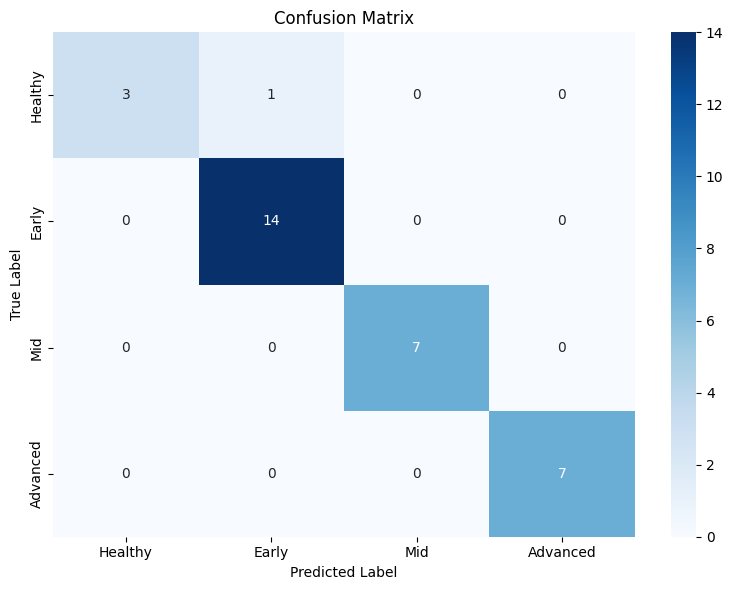


📊 Training Metrics:
      Metric    Value
   Accuracy 0.968750
 Error Rate 0.031250
  Precision 0.970833
     Recall 0.968750
   F1 Score 0.967057
    ROC AUC 0.990327
        MSE 0.038051
       RMSE 0.195067
        TPR 1.000000
        TNR 0.750000
        FPR 0.250000
        FNR 0.000000
 Dense Rate 0.000000
Dense Ratio 0.000000


In [ ]:
# UNet Model Training

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Input, UpSampling2D, Concatenate, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from PIL import Image

# Load and clean CSV
label_csv_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Metadata\Label Data.csv"
df = pd.read_csv(label_csv_path)
df.columns = df.columns.str.strip()

# Mapping
label_map = {0: "Healthy Liver", 1: "Early Stage Cirrhosis", 2: "Mid Stage Cirrhosis", 3: "Advanced Stage Cirrhosis"}
gender_map = {1: "Female", 2: "Male"}

# Apply mappings
df["Label_Name"] = df["Radiological Evaluation"].map(label_map)
df["Gender_Name"] = df["Gender"].map(gender_map)

# Train Data Paths 
train_dirs = [
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T1_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T2_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T1_W_Healthy\T1_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T2_W_Healthy\T2_images"
]

# Prepare image info
image_info = []
for train_dir in train_dirs:
    for file in os.listdir(train_dir):
        if file.endswith(".jpg"):
            path = os.path.join(train_dir, file)
            try:
                patient_id = int(file.split("_")[0])
                matched = df[df["Patient ID"] == patient_id]
                if not matched.empty:
                    label = matched["Radiological Evaluation"].values[0]
                    age = matched["Age"].values[0]
                    gender = matched["Gender"].values[0]
                    image_info.append((path, label, age, gender))
            except:
                continue

# DataGenerator
class LiverDataGenerator(Sequence):
    def __init__(self, image_info, batch_size=32, image_size=(128, 128), shuffle=True):
        self.image_info = image_info
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.image_info) / self.batch_size))
    
    def __getitem__(self, index):
        batch_info = self.image_info[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_labels = [], []
        self.dense_rates, self.dense_ratios = [], []
        
        for path, label, age, gender in batch_info:
            try:
                img = Image.open(path).resize(self.image_size).convert("RGB")
                img_np = np.array(img) / 255.0

                green_mask = (img_np[:, :, 1] > 100) & (img_np[:, :, 0] < 80) & (img_np[:, :, 2] < 80)
                liver_pixels = np.sum(green_mask)
                total_pixels = self.image_size[0] * self.image_size[1]

                dense_rate = liver_pixels / total_pixels
                dense_ratio = liver_pixels / (np.count_nonzero(np.sum(img_np, axis=2)) + 1)

                self.dense_rates.append(dense_rate)
                self.dense_ratios.append(dense_ratio)

                batch_images.append(img_np)
                batch_labels.append(label)
            except:
                continue
        
        X = np.array(batch_images)
        y = to_categorical(batch_labels, num_classes=4)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_info)

# Generator
train_generator = LiverDataGenerator(image_info, batch_size=32)

# U-Net Architecture for classification
def build_unet_classifier(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    bn = Conv2D(512, 3, activation='relu', padding='same')(p3)

    # Decoder (not used here, instead we flatten + classify)
    f = Flatten()(bn)
    d1 = Dense(256, activation='relu')(f)
    d2 = Dropout(0.4)(d1)
    outputs = Dense(num_classes, activation='softmax')(d2)

    model = Model(inputs, outputs)
    return model

model = build_unet_classifier()

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator, epochs=1)

# Save model
model.save("unet_model.h5")

# Predict on first batch
X_test, y_test = train_generator[0]
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
labels = ["Healthy", "Early", "Mid", "Advanced"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_image.png")
plt.show()

# Classification Metrics
report = classification_report(y_true, y_pred_classes, output_dict=True)
roc_auc = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

TP = conf_matrix[1][1] if conf_matrix.shape[0] > 1 else 0
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] if conf_matrix.shape[1] > 1 else 0
FN = conf_matrix[1][0] if conf_matrix.shape[0] > 1 else 0

accuracy = np.trace(conf_matrix) / conf_matrix.sum()
error_rate = 1 - accuracy
tpr = TP / (TP + FN) if (TP + FN) else 0
tnr = TN / (TN + FP) if (TN + FP) else 0
fpr = FP / (FP + TN) if (FP + TN) else 0
fnr = FN / (FN + TP) if (FN + TP) else 0

avg_dense_rate = np.mean(train_generator.dense_rates)
avg_dense_ratio = np.mean(train_generator.dense_ratios)

# Metrics Table
metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Error Rate", "Precision", "Recall", "F1 Score", "ROC AUC", "MSE", "RMSE", "TPR", "TNR", "FPR", "FNR", "Dense Rate", "Dense Ratio"],
    "Value": [
        accuracy,
        error_rate,
        report["weighted avg"]["precision"],
        report["weighted avg"]["recall"],
        report["weighted avg"]["f1-score"],
        roc_auc,
        mse,
        rmse,
        tpr,
        tnr,
        fpr,
        fnr,
        avg_dense_rate,
        avg_dense_ratio
    ]
})

print("\n📊 Training Metrics:\n", metrics_table.to_string(index=False))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1216/1216 ━━━━━━━━━━━━━━━━━━━━ 617s 501ms/step - accuracy: 0.4178 - loss: 1.2938


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


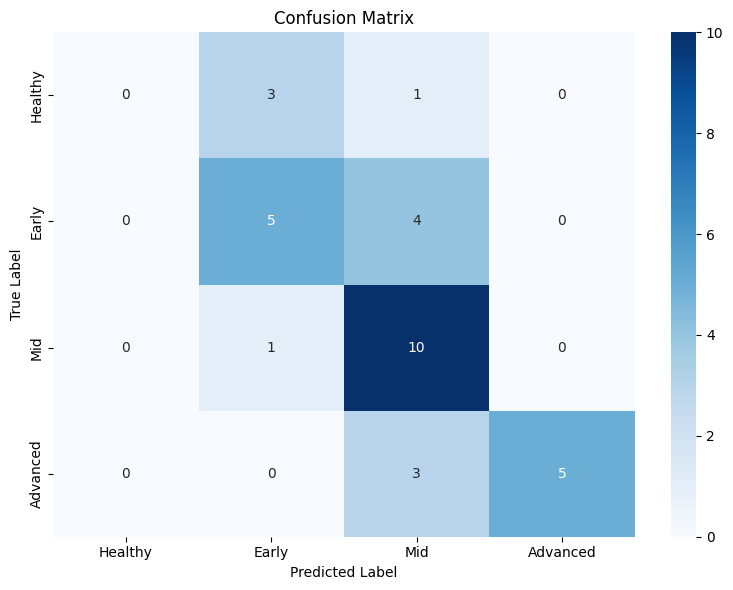


📊 Training Metrics:
      Metric    Value
   Accuracy 0.625000
 Error Rate 0.375000
  Precision 0.597222
     Recall 0.625000
   F1 Score 0.585627
    ROC AUC 0.901096
        MSE 0.117304
       RMSE 0.342497
        TPR 1.000000
        TNR 0.000000
        FPR 1.000000
        FNR 0.000000
 Dense Rate 0.000000
Dense Ratio 0.000000


C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Name\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

In [ ]:
# DenseNet Model Training 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from PIL import Image

# Load and clean CSV
label_csv_path = r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Metadata\Label Data.csv"
df = pd.read_csv(label_csv_path)
df.columns = df.columns.str.strip()

# Mapping
label_map = {0: "Healthy Liver", 1: "Early Stage Cirrhosis", 2: "Mid Stage Cirrhosis", 3: "Advanced Stage Cirrhosis"}
gender_map = {1: "Female", 2: "Male"}

# Apply mappings
df["Label_Name"] = df["Radiological Evaluation"].map(label_map)
df["Gender_Name"] = df["Gender"].map(gender_map)

# Train Data Paths 
train_dirs = [
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T1_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Cirrhosis_T2_3D\train_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T1_W_Healthy\T1_images",
    r"C:\Users\Name\Documents\STUDIES\CAPSTON-2\CirrMRI600+\Segmented Images\Healthy_subjects\T2_W_Healthy\T2_images"
]

# Prepare image info
image_info = []
for train_dir in train_dirs:
    for file in os.listdir(train_dir):
        if file.endswith(".jpg"):
            path = os.path.join(train_dir, file)
            try:
                patient_id = int(file.split("_")[0])
                matched = df[df["Patient ID"] == patient_id]
                if not matched.empty:
                    label = matched["Radiological Evaluation"].values[0]
                    age = matched["Age"].values[0]
                    gender = matched["Gender"].values[0]
                    image_info.append((path, label, age, gender))
            except:
                continue

# DataGenerator
class LiverDataGenerator(Sequence):
    def __init__(self, image_info, batch_size=32, image_size=(128, 128), shuffle=True):
        self.image_info = image_info
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.image_info) / self.batch_size))
    
    def __getitem__(self, index):
        batch_info = self.image_info[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_labels = [], []
        self.dense_rates, self.dense_ratios = [], []
        
        for path, label, age, gender in batch_info:
            try:
                img = Image.open(path).resize(self.image_size).convert("RGB")
                img_np = np.array(img) / 255.0

                green_mask = (img_np[:, :, 1] > 100) & (img_np[:, :, 0] < 80) & (img_np[:, :, 2] < 80)
                liver_pixels = np.sum(green_mask)
                total_pixels = self.image_size[0] * self.image_size[1]

                dense_rate = liver_pixels / total_pixels
                dense_ratio = liver_pixels / (np.count_nonzero(np.sum(img_np, axis=2)) + 1)

                self.dense_rates.append(dense_rate)
                self.dense_ratios.append(dense_ratio)

                batch_images.append(img_np)
                batch_labels.append(label)
            except:
                continue
        
        X = np.array(batch_images)
        y = to_categorical(batch_labels, num_classes=4)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_info)

# Generator
train_generator = LiverDataGenerator(image_info, batch_size=32)

# DenseNet121 Architecture (instead of GCNN)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator, epochs=1)

# Save model
model.save("densenet_model.h5")

# Predict on first batch
X_test, y_test = train_generator[0]
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
labels = ["Healthy", "Early", "Mid", "Advanced"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_image.png")
plt.show()

# Classification Metrics
report = classification_report(y_true, y_pred_classes, output_dict=True)
roc_auc = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

TP = conf_matrix[1][1] if conf_matrix.shape[0] > 1 else 0
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] if conf_matrix.shape[1] > 1 else 0
FN = conf_matrix[1][0] if conf_matrix.shape[0] > 1 else 0

accuracy = np.trace(conf_matrix) / conf_matrix.sum()
error_rate = 1 - accuracy
tpr = TP / (TP + FN) if (TP + FN) else 0
tnr = TN / (TN + FP) if (TN + FP) else 0
fpr = FP / (FP + TN) if (FP + TN) else 0
fnr = FN / (FN + TP) if (FN + TP) else 0

avg_dense_rate = np.mean(train_generator.dense_rates)
avg_dense_ratio = np.mean(train_generator.dense_ratios)

# Metrics Table
metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Error Rate", "Precision", "Recall", "F1 Score", "ROC AUC", "MSE", "RMSE", "TPR", "TNR", "FPR", "FNR", "Dense Rate", "Dense Ratio"],
    "Value": [
        accuracy,
        error_rate,
        report["weighted avg"]["precision"],
        report["weighted avg"]["recall"],
        report["weighted avg"]["f1-score"],
        roc_auc,
        mse,
        rmse,
        tpr,
        tnr,
        fpr,
        fnr,
        avg_dense_rate,
        avg_dense_ratio
    ]
})

print("\n📊 Training Metrics:\n", metrics_table.to_string(index=False))


In [39]:
import pandas as pd
from tabulate import tabulate

# Define model metrics
metrics_data = {
    "Model": ["CNN", "GCNN", "ResNet50", "UNet", "DenseNet"],
    "Accuracy": [0.875, 0.875, 0.4375, 0.96875, 0.625],
    "Error Rate": [0.125, 0.125, 0.5625, 0.03125, 0.375],
    "Precision": [0.882468, 0.898214, 0.46503, 0.970833, 0.597222],
    "Recall": [0.875, 0.875, 0.4375, 0.96875, 0.625],
    "F1 Score": [0.875021, 0.867521, 0.383602, 0.967057, 0.585627],
    "ROC AUC": [0.973509, 0.992505, 0.734901, 0.990327, 0.901096]
}

# Create the DataFrame
df = pd.DataFrame(metrics_data)
df.set_index("Model", inplace=True)

# Print the table with borders
print("\n📋 Metric-Wise Performance of Trained Models:\n")
print(tabulate(df.round(4), headers='keys', tablefmt='fancy_grid'))



📋 Metric-Wise Performance of Trained Models:

╒══════════╤════════════╤══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Model    │   Accuracy │   Error Rate │   Precision │   Recall │   F1 Score │   ROC AUC │
╞══════════╪════════════╪══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ CNN      │     0.875  │       0.125  │      0.8825 │   0.875  │     0.875  │    0.9735 │
├──────────┼────────────┼──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ GCNN     │     0.875  │       0.125  │      0.8982 │   0.875  │     0.8675 │    0.9925 │
├──────────┼────────────┼──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ResNet50 │     0.4375 │       0.5625 │      0.465  │   0.4375 │     0.3836 │    0.7349 │
├──────────┼────────────┼──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ UNet     │     0.9688 │       0.0312 │      0.9708 │   0.9688 │     0.9671 │    0.9903 │
├──────────┼────────────┼──────────────┼───

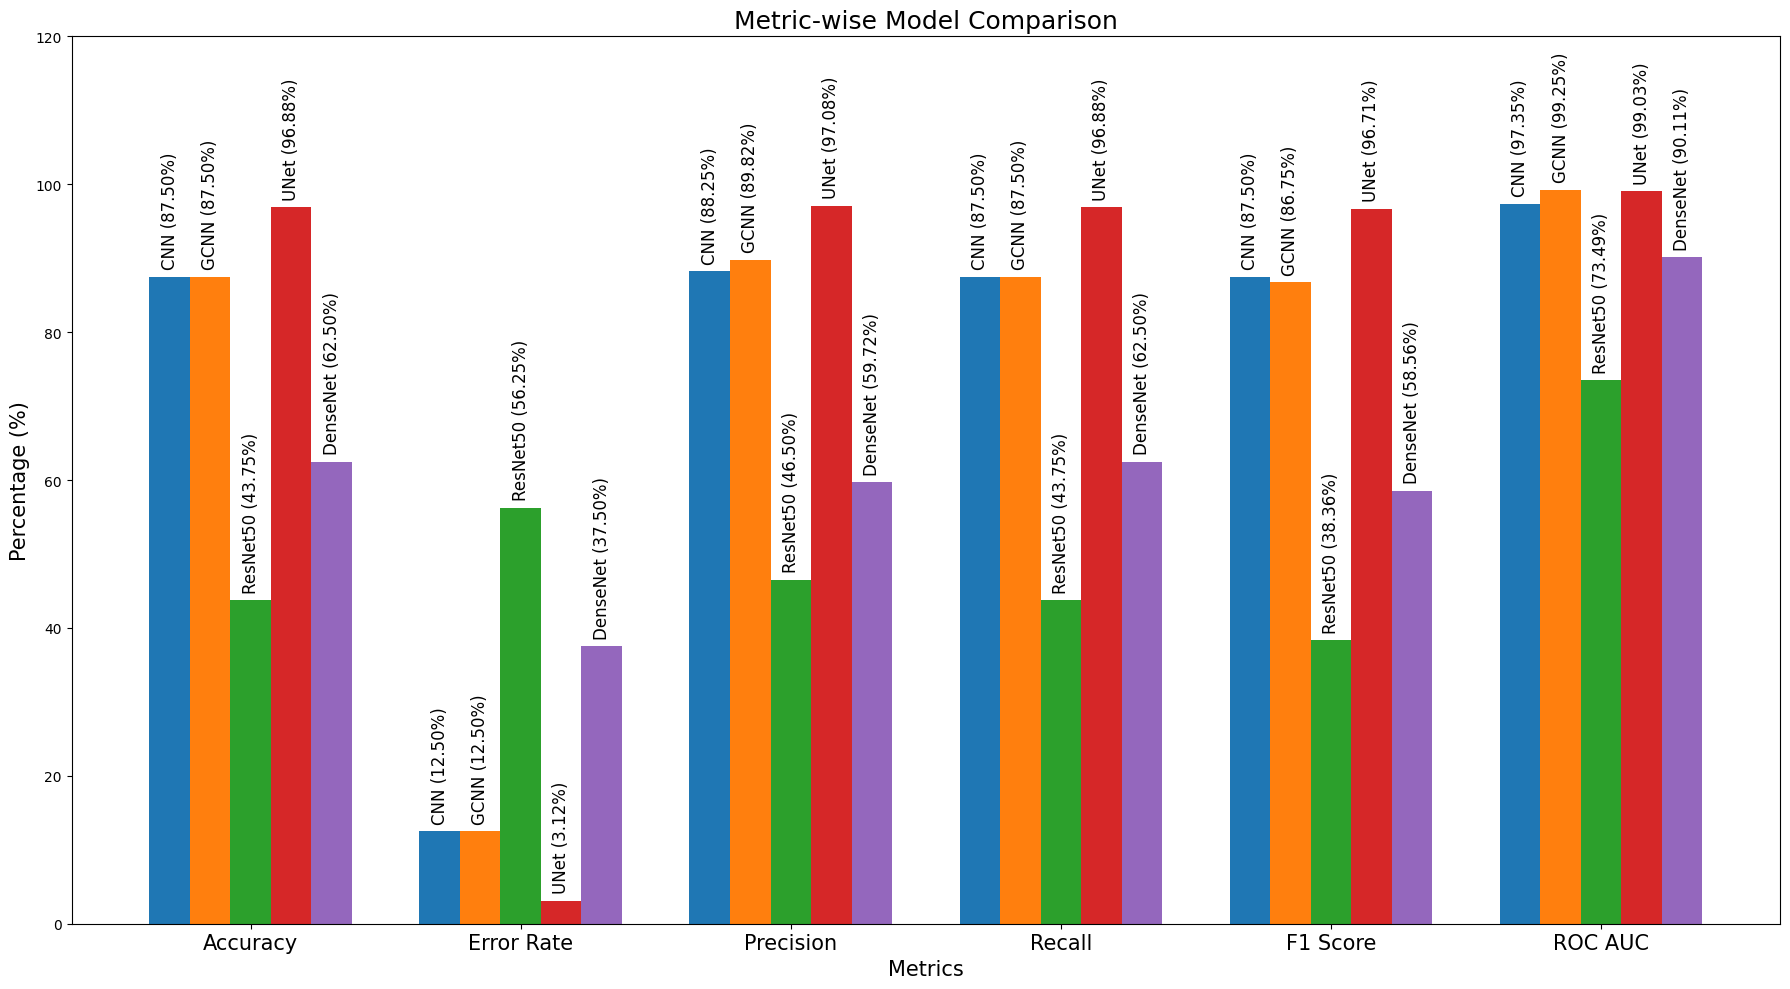

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# 🎯 Metrics to compare
metrics = ["Accuracy", "Error Rate", "Precision", "Recall", "F1 Score", "ROC AUC"]

# ✅ Get model names from index and metric values as percentages
models = df.index.tolist()
scores = [df[metric].values * 100 for metric in metrics]  # Convert to percentage

# 🔢 Chart setup
bar_width = 0.15
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(18, 10))

# 🧱 Plot each model
for i, model in enumerate(models):
    offset = (i - (len(models)-1)/2) * bar_width
    bars = ax.bar(x + offset, [score[i] for score in scores], width=bar_width, label=model)

    # ✍️ Show model name and percentage on each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        label = f"{model} ({height:.2f}%)"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1,
            label,
            ha='center',
            va='bottom',
            fontsize=12,
            rotation=90
        )

# 🎨 Style chart
ax.set_xlabel("Metrics", fontsize=15)
ax.set_ylabel("Percentage (%)", fontsize=15)
ax.set_title("Metric-wise Model Comparison", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=15)
ax.set_ylim(0, 120)

plt.tight_layout()
plt.show()


Model Training Result:

Highest _accuracy = 96.88% for UNet Model

so we can say that the UNet model is the best model for this dataset.

We are going to use the UNet model for the Cirrhosis Detection

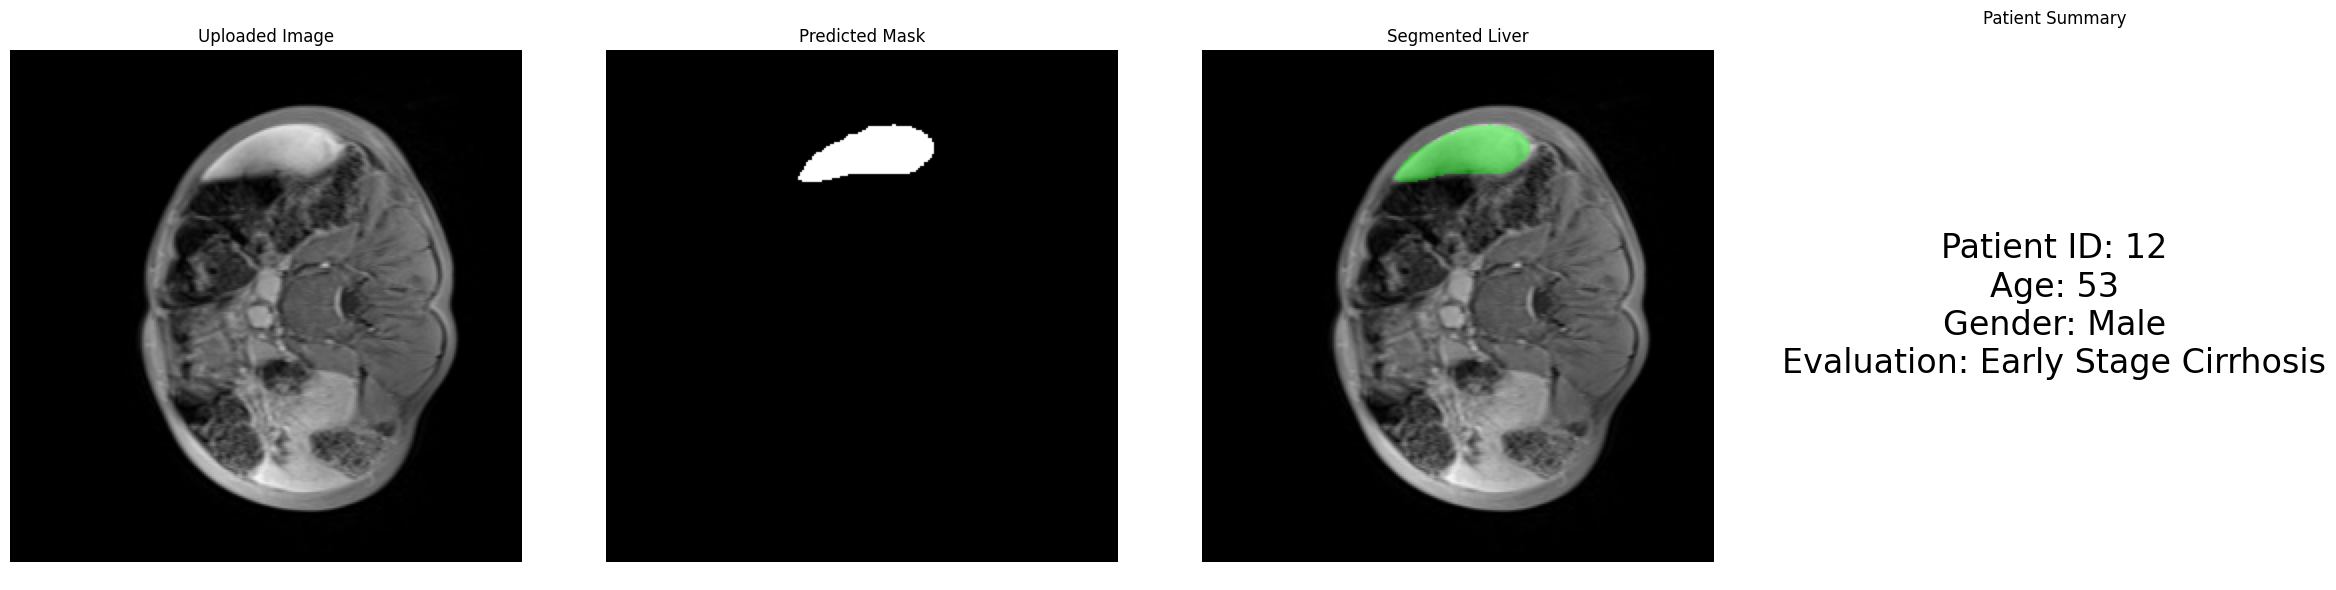

In [ ]:
# Liver Cirrhosis Detection Using UNet Model

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import display, clear_output
import ipywidgets as widgets
import re

# Load your trained model
model = load_model(r"C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\unet_model.h5")

# Class labels
class_labels = ['Cirrhosis_T1', 'Cirrhosis_T2', 'Healthy_T1', 'Healthy_T2']

# Define mappings for evaluation and gender
evaluation_map = {
    0: "Healthy Liver",
    1: "Early Stage Cirrhosis",
    2: "Mid Stage Cirrhosis",
    3: "Advanced Stage Cirrhosis",
}

gender_map = {
    1: "Female",
    2: "Male"
}

mask_dirs = [
    r'C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Sliced\Cirrhosis_T1_3D\test_masks',
    r'C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Sliced\Cirrhosis_T1_3D\train_masks',
    r'C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Sliced\Cirrhosis_T1_3D\valid_masks',
    r'C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Sliced\Cirrhosis_T2_3D\test_masks',
    r'C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Sliced\Cirrhosis_T2_3D\train_masks',
    r'C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Sliced\Cirrhosis_T2_3D\valid_masks',
    r'C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Sliced\Healthy_subjects\T1_W_Healthy\train_masks',
    r'C:\Users\Name\Documents\STUDIES\Liver Cirrhosis\Sliced\Healthy_subjects\T2_W_Healthy\train_masks'
]

def get_metadata_by_filename(filename):
    """
    Extract Patient ID from filename and return corresponding metadata.
    """
    base_name = os.path.basename(filename)
    match = re.match(r"^(\d+)", base_name)
    if match:
        patient_id = int(match.group(1))
        row = df_labels[df_labels["Patient ID"] == patient_id]
        if not row.empty:
            return row.iloc[0]  
    return None  

def find_mask_by_filename(image_name):
    for mask_dir in mask_dirs:
        mask_path = os.path.join(mask_dir, image_name)
        if os.path.exists(mask_path):
            return mask_path
    return None

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return np.expand_dims(img_array, axis=0)

def overlay_mask_exact(image, mask, alpha=0.4):
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    
    mask_bin = (mask > 0).astype(np.uint8)
    green = np.zeros_like(image, dtype=np.uint8)
    green[:, :] = (0, 255, 0)  

    mask_rgb = np.stack([mask_bin]*3, axis=-1)

    blended = image.copy()
    blended[mask_rgb == 1] = cv2.addWeighted(image, 1 - alpha, green, alpha, 0)[mask_rgb == 1]

    return blended

def show_result(fileinfo):
    filename = fileinfo['name']

    # Read image bytes and decode original image
    file_bytes = fileinfo['content']
    img_array = np.frombuffer(file_bytes, np.uint8)
    img_bgr = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Save temporarily and preprocess separately for prediction
    temp_path = "temp_image.jpg"
    cv2.imwrite(temp_path, img_bgr)
    preprocessed_img = preprocess_image(temp_path)  # 128x128 for model
    os.remove(temp_path)

    # Predict the label
    prediction = model.predict(preprocessed_img)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]

    # Find corresponding mask
    mask_path = find_mask_by_filename(filename)

    # Get metadata
    metadata_row = get_metadata_by_filename(filename)
    if metadata_row is not None:
        gender_code = int(metadata_row['Gender']) if pd.notna(metadata_row['Gender']) else None
        gender_str = gender_map.get(gender_code, "Unknown")

        evaluation_label = metadata_row['Radiological Evaluation']
        evaluation_label = evaluation_map.get(int(evaluation_label), f"Unknown ({evaluation_label})") if pd.notna(evaluation_label) else "Not Available"

        metadata_text = (
            f"Patient ID: {metadata_row['Patient ID']}\n"
            f"Age: {metadata_row['Age']}\n"
            f"Gender: {gender_str}\n"
            f"Evaluation: {evaluation_label}"
        )
    else:
        metadata_text = "Metadata Not Available"

    # === Display results ===
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))

    # Show original image
    ax[0].imshow(img_rgb)
    ax[0].set_title("Uploaded Image")
    ax[0].axis('off')

    # Mask processing and overlay
    if mask_path:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        ax[1].imshow(binary_mask, cmap='gray')
        ax[1].set_title("Predicted Mask")
        ax[1].axis('off')

        overlay = overlay_mask_exact(img_rgb, binary_mask)
        ax[2].imshow(overlay)
        ax[2].set_title("Segmented Liver")
        ax[2].axis('off')
    else:
        ax[1].text(0.5, 0.5, "Mask Not Found", ha='center', va='center', fontsize=14)
        ax[1].axis('off')

        ax[2].imshow(img_rgb)
        ax[2].set_title("Original (No Mask)")
        ax[2].axis('off')

    # Patient info
    summary_text = f"{metadata_text}"
    ax[3].text(0.5, 0.5, summary_text, fontsize=24, ha='center', va='center', wrap=True)
    ax[3].set_title("Patient Summary")
    ax[3].axis('off')

    plt.tight_layout()
    plt.show()


# Upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

# Event handler
def handle_upload(change):
    clear_output(wait=True)
    if upload_widget.value:
        fileinfo = upload_widget.value[0]
        show_result(fileinfo)

upload_widget.observe(handle_upload, names='value')
display(upload_widget)